In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbackes import ModelCheckpoint
from cfg import Config

Using TensorFlow backend.


In [2]:
def build_rand_feat():
    x = []
    y = []
    _min, _max = float('inf'), -float('inf')
    
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label == rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step )
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample, rate,
                       numcep =config.nfeat, nfilt = config.nfilt, nfft= config.nfft)
        _min = min(np.amin(X_sample),_min)
        _max = max(np.amax(X_sample),_max)
        x.append(X_sample)
        y.append(classes.index(label))
    config.min = _min 
    config.max = _max
    x, y = np.array(x), np.array(y)
    x = (x - _min)/(_max - _min)
    
    if config.mode =='conv':
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
    elif config.mode =='time':
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2])
    y = to_categorical(y, num_classes =10)
    return x,y

In [8]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation = 'relu', strides = (1,1),
                    padding = 'same', input_shape = input_shape))
    model.add(Conv2D(32, (3,3), activation = 'relu', strides = (1,1),
                    padding = 'same', input_shape = input_shape))
    model.add(Conv2D(64, (3,3), activation = 'relu', strides = (1,1),
                    padding = 'same', input_shape = input_shape))
    model.add(Conv2D(128, (3,3), activation = 'relu', strides = (1,1),
                    padding = 'same', input_shape = input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(10, activation = 'softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer = 'adam',
                 metrics =['acc'])
    return model

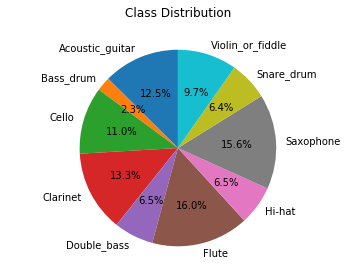

In [5]:
df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2* int(df['length'].sum()/0.1)
prob_dist = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p = prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [9]:
config = Config(mode='conv')
if config.mode == 'conv':
    X,y = build_rand_feat()
    y_flat = np.argmax(y, axis =1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
    
elif config.mode == 'time':
    X,y = build_rand_feat()
    y_flat = np.argmax(y, axis =1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    
class_weight = compute_class_weight('balanced', 
                                   np.unique(y_flat),
                                   y_flat)
model.fit(X, y, epochs= 10, batch_size = 32,
         shuffle=True, class_weight = class_weight ) 

100%|██████████| 26410/26410 [01:04<00:00, 409.47it/s]


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 13, 9, 16)         160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 9, 32)         4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 9, 64)         18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 9, 128)        73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 4, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 4, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)             

(26410, 13, 9, 1)
